# Improving Agents Behaviors

## Prediction vs. Control vs. Policy Evaluation vs. Improvement

**Prediction problem**: The problem of estimating value functions given a policy. Estimating value functions is nothing but learning to predict returns. **State-value functions** estimate expected returns from *states*, and **action-value functions** estimate expected returns from *state-action pairs*

**Control problem**: The problem of finding optimal policies. Solved by following the pattern of *Generalized Policy Iteration* (GPI), where the competing processes of policy evaluation and policy improvement progressively move policies towards optimality.

**Policy Evaluation**: The algorithms that solve the prediction problem

**Policy Improvement**: The algorithms that make new policies that improve on the original policy by making it greedier than the original with respect to the value function of the original policy. Often, a policy evaluation must be paired with a policy improvement to solve the control problem

In [1]:
import warnings ; warnings.filterwarnings('ignore')

import itertools
import gym, gym_walk, gym_aima
import numpy as np
from tabulate import tabulate
from pprint import pprint
from tqdm import tqdm_notebook as tqdm
from itertools import cycle, count

import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline

In [2]:
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

In [3]:
def value_iteration(P, gamma=1.0, theta=1e-10):
    V = np.zeros(len(P), dtype=np.float64)
    while True:
        Q = np.zeros((len(P), len(P[0])), dtype=np.float64)
        for s in range(len(P)):
            for a in range(len(P[s])):
                for prob, next_state, reward, done in P[s][a]:
                    Q[s][a] += prob * (reward + gamma * V[next_state] * (not done))
        if np.max(np.abs(V - np.max(Q, axis=1))) < theta:
            break
        V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi

In [4]:
def print_policy(pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4, title='Policy:'):
    print(title)
    arrs = {k:v for k,v in enumerate(action_symbols)}
    for s in range(len(P)):
        a = pi(s)
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), arrs[a].rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [5]:
def print_state_value_function(V, P, n_cols=4, prec=3, title='State-value function:'):
    print(title)
    for s in range(len(P)):
        v = V[s]
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), '{}'.format(np.round(v, prec)).rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [6]:
def print_action_value_function(Q, 
                                optimal_Q=None, 
                                action_symbols=('<', '>'), 
                                prec=3, 
                                title='Action-value function:'):
    vf_types=('',) if optimal_Q is None else ('', '*', 'err')
    headers = ['s',] + [' '.join(i) for i in list(itertools.product(vf_types, action_symbols))]
    print(title)
    states = np.arange(len(Q))[..., np.newaxis]
    arr = np.hstack((states, np.round(Q, prec)))
    if not (optimal_Q is None):
        arr = np.hstack((arr, np.round(optimal_Q, prec), np.round(optimal_Q-Q, prec)))
    print(tabulate(arr, headers, tablefmt="fancy_grid"))

In [7]:
def get_policy_metrics(env, gamma, pi, goal_state, optimal_Q, 
                       n_episodes=100, max_steps=200):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    reached_goal, episode_reward, episode_regret = [], [], []
    for _ in range(n_episodes):
        state, done, steps = env.reset(), False, 0
        episode_reward.append(0.0)
        episode_regret.append(0.0)
        while not done and steps < max_steps:
            action = pi(state)
            regret = np.max(optimal_Q[state]) - optimal_Q[state][action]
            episode_regret[-1] += regret
            
            state, reward, done, _ = env.step(action)
            episode_reward[-1] += (gamma**steps * reward)
            
            steps += 1

        reached_goal.append(state == goal_state)
    results = np.array((np.sum(reached_goal)/len(reached_goal)*100, 
                        np.mean(episode_reward), 
                        np.mean(episode_regret)))
    return results

In [8]:
def get_metrics_from_tracks(env, gamma, goal_state, optimal_Q, pi_track, coverage=0.1):
    total_samples = len(pi_track)
    n_samples = int(total_samples * coverage)
    samples_e = np.linspace(0, total_samples, n_samples, endpoint=True, dtype=np.int)
    metrics = []
    for e, pi in enumerate(tqdm(pi_track)):
        if e in samples_e:
            metrics.append(get_policy_metrics(
                env, 
                gamma=gamma, 
                pi=lambda s: pi[s], 
                goal_state=goal_state, 
                optimal_Q=optimal_Q))
        else:
            metrics.append(metrics[-1])
    metrics = np.array(metrics)
    success_rate_ma, mean_return_ma, mean_regret_ma = np.apply_along_axis(moving_average, axis=0, arr=metrics).T
    return success_rate_ma, mean_return_ma, mean_regret_ma 

In [9]:
def rmse(x, y, dp=4):
    return np.round(np.sqrt(np.mean((x - y)**2)), dp)


def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [10]:
def plot_value_function(title, V_track, V_true=None, log=False, limit_value=0.05, limit_items=5):
    np.random.seed(123)
    per_col = 25
    linecycler = cycle(["-","--",":","-."])
    legends = []

    valid_values = np.argwhere(V_track[-1] > limit_value).squeeze()
    items_idxs = np.random.choice(valid_values, 
                                  min(len(valid_values), limit_items), 
                                  replace=False)
    # draw the true values first
    if V_true is not None:
        for i, state in enumerate(V_track.T):
            if i not in items_idxs:
                continue
            if state[-1] < limit_value:
                continue

            label = 'v*({})'.format(i)
            plt.axhline(y=V_true[i], color='k', linestyle='-', linewidth=1)
            plt.text(int(len(V_track)*1.02), V_true[i]+.01, label)

    # then the estimates
    for i, state in enumerate(V_track.T):
        if i not in items_idxs:
            continue
        if state[-1] < limit_value:
            continue
        line_type = next(linecycler)
        label = 'V({})'.format(i)
        p, = plt.plot(state, line_type, label=label, linewidth=3)
        legends.append(p)
        
    legends.reverse()

    ls = []
    for loc, idx in enumerate(range(0, len(legends), per_col)):
        subset = legends[idx:idx+per_col]
        l = plt.legend(subset, [p.get_label() for p in subset], 
                       loc='center right', bbox_to_anchor=(1.25, 0.5))
        ls.append(l)
    [plt.gca().add_artist(l) for l in ls[:-1]]
    if log: plt.xscale('log')
    plt.title(title)
    plt.ylabel('State-value function')
    plt.xlabel('Episodes (log scale)' if log else 'Episodes')
    plt.show()

In [11]:
env = gym.make('SlipperyWalkSeven-v0')
init_state = env.reset()
goal_state = 8
gamma = 0.99
n_episodes = 3000
P = env.env.P
n_cols, svf_prec, err_prec, avf_prec=9, 4, 2, 3
action_symbols=('<', '>')
limit_items, limit_value = 5, 0.0
cu_limit_items, cu_limit_value, cu_episodes = 10, 0.0, 100

d:\OneDrive\Documents\Coding\Anaconda\envs\rl-env\lib\site-packages\gym\core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
d:\OneDrive\Documents\Coding\Anaconda\envs\rl-env\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [12]:
def decay_schedule(
        init_value, min_value,
        decay_ratio, max_steps,
        log_start=-2, log_base=10):

    decay_steps = int(max_steps * decay_ratio)
    rem_steps = max_steps - decay_steps

    values = np.logspace(
        log_start, 0, decay_steps,
        base=log_base, endpoint=True
    )[::-1]

    values = (values - values.min()) / (values.max() - values.min())

    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values


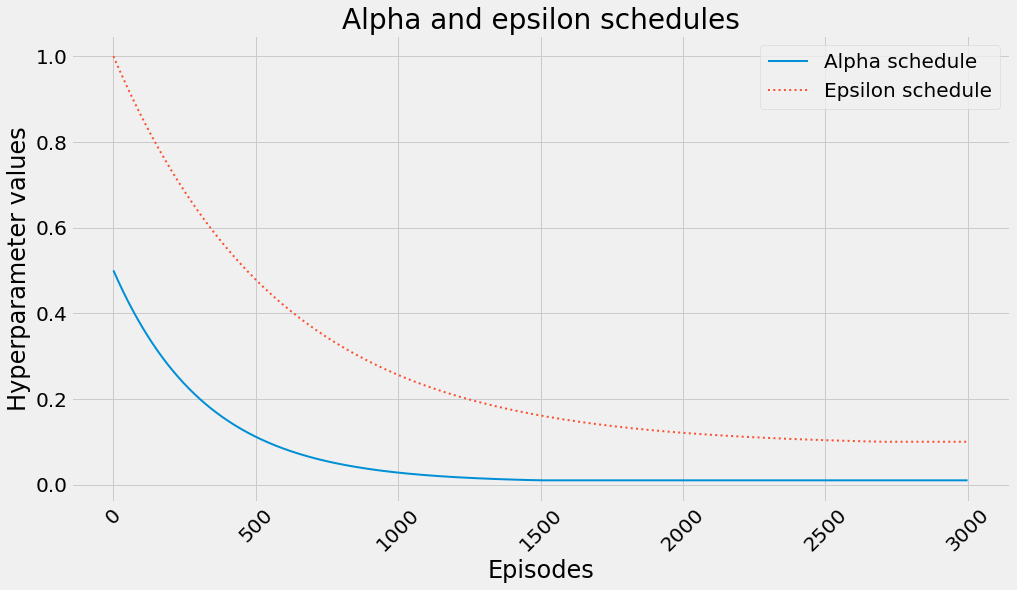

In [13]:
plt.plot(decay_schedule(0.5, 0.01, 0.5, n_episodes), 
         '-', linewidth=2, 
         label='Alpha schedule')
plt.plot(decay_schedule(1.0, 0.1, 0.9, n_episodes), 
         ':', linewidth=2, 
         label='Epsilon schedule')
plt.legend(loc=1, ncol=1)

plt.title('Alpha and epsilon schedules')
plt.xlabel('Episodes')
plt.ylabel('Hyperparameter values')
plt.xticks(rotation=45)

plt.show()

In [14]:
optimal_Q, optimal_V, optimal_pi = value_iteration(P, gamma=gamma)
print_state_value_function(optimal_V, P, n_cols=n_cols, prec=svf_prec, title='Optimal state-value function:')
print()

print_action_value_function(optimal_Q, 
                            None, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Optimal action-value function:')
                            
print_policy(optimal_pi, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_op, mean_return_op, mean_regret_op = get_policy_metrics(
    env, gamma=gamma, pi=optimal_pi, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_op, mean_return_op, mean_regret_op))

Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |

Optimal action-value function:
╒═════╤═══════╤═══════╕
│   s │     < │     > │
╞═════╪═══════╪═══════╡
│   0 │ 0     │ 0     │
├─────┼───────┼───────┤
│   1 │ 0.312 │ 0.564 │
├─────┼───────┼───────┤
│   2 │ 0.67  │ 0.763 │
├─────┼───────┼───────┤
│   3 │ 0.803 │ 0.845 │
├─────┼───────┼───────┤
│   4 │ 0.864 │ 0.889 │
├─────┼───────┼───────┤
│   5 │ 0.901 │ 0.922 │
├─────┼───────┼───────┤
│   6 │ 0.932 │ 0.952 │
├─────┼───────┼───────┤
│   7 │ 0.961 │ 0.981 │
├─────┼───────┼───────┤
│   8 │ 0     │ 0     │
╘═════╧═══════╧═══════╛
Policy:
|           | 01      > | 02      > | 03      > | 04      > | 05      > | 06      > | 07      > |           |
Reaches goal 96.00%. Obtains an average return of 0.8672. Regret of 0.0000


d:\OneDrive\Documents\Coding\Anaconda\envs\rl-env\lib\site-packages\gym\core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
d:\OneDrive\Documents\Coding\Anaconda\envs\rl-env\lib\site-packages\gym\utils\passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


## FVMC control: Improving policies after each episode


Monte-Carlo prediction is used as the policy-evaluation. A small change to the MC algo is necessary, it needs to estimate the action-value function $Q(s, a)$ instead of the state-value function $V(s, a)$

![Image](./Image01.png)


In [15]:
def generate_trajectory(select_action, Q, epsilon, env, max_steps=200):
    done, trajectory = False, []
    while not done:
        state = env.reset()
        for t in count():
            action = select_action(state, Q, epsilon)
            next_state, reward, done, _ = env.step(action)
            experience = (state, action, reward, next_state, done)
            trajectory.append(experience)
            if done:
                break
            if t >= max_steps - 1:
                trajectory = []
                break
            state = next_state
    return np.array(trajectory, np.object)

In [16]:
def mc_control(env,
               gamma=1.0,
               init_alpha=0.5,
               min_alpha=0.01,
               alpha_decay_ratio=0.5,
               init_epsilon=1.0,
               min_epsilon=0.1,
               epsilon_decay_ratio=0.9,
               n_episodes=3000,
               max_steps=200,
               first_visit=True):
    nS, nA = env.observation_space.n, env.action_space.n

    discounts = np.logspace(0, 
                            max_steps, 
                            num=max_steps, 
                            base=gamma, 
                            endpoint=False) 
    alphas = decay_schedule(init_alpha, 
                           min_alpha, 
                           alpha_decay_ratio, 
                           n_episodes)
    epsilons = decay_schedule(init_epsilon, 
                              min_epsilon, 
                              epsilon_decay_ratio, 
                              n_episodes)

    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)

    # lambda function Q(s, a) using a epsilon-greedy strategy
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))

    for e in tqdm(range(n_episodes), leave=False):
        trajectory = generate_trajectory(select_action,
                                         Q,
                                         epsilons[e],
                                         env, 
                                         max_steps)

        # Apply MC
        visited = np.zeros((nS, nA), dtype=np.bool)

        for t, (state, action, reward, _, _) in enumerate(trajectory):
            if visited[state][action] and first_visit:
                continue
            visited[state][action] = True
            
            n_steps = len(trajectory[t:])
            G = np.sum(discounts[:n_steps] * trajectory[t:, 2])
            Q[state][action] = Q[state][action] + alphas[e] * (G - Q[state][action])

        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1))
    
    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, pi_track

In [17]:
%%capture
Q_mcs, V_mcs, Q_track_mcs = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed)
    np.random.seed(seed)
    env.seed(seed)
    Q_mc, V_mc, pi_mc, Q_track_mc, pi_track_mc = mc_control(env, gamma=gamma, n_episodes=n_episodes)
    Q_mcs.append(Q_mc)
    V_mcs.append(V_mc)
    Q_track_mcs.append(Q_track_mc)
Q_mc, V_mc, Q_track_mc = np.mean(Q_mcs, axis=0), np.mean(V_mcs, axis=0), np.mean(Q_track_mcs, axis=0)
del Q_mcs ; del V_mcs ; del Q_track_mcs

In [18]:
print_state_value_function(V_mc, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by FVMC:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_mc - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_mc, optimal_V)))
print()
print_action_value_function(Q_mc, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='FVMC action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_mc, optimal_Q)))
print()
print_policy(pi_mc, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_mc, mean_return_mc, mean_regret_mc = get_policy_metrics(
    env, gamma=gamma, pi=pi_mc, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_mc, mean_return_mc, mean_regret_mc))

State-value function found by FVMC:
|           | 01  0.502 | 02 0.7282 | 03 0.8219 | 04 0.8735 | 05 0.9146 | 06 0.9457 | 07 0.9797 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01  -0.06 | 02  -0.03 | 03  -0.02 | 04  -0.02 | 05  -0.01 | 06  -0.01 | 07   -0.0 |           |
State-value function RMSE: 0.0256

FVMC action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╕
│   s │     < │     > │   * < │   * > │   err < │   err > │
╞═════╪═══════╪═══════╪═══════╪═══════╪═════════╪═════════╡
│   0 │ 0     │ 0     │ 0     │ 0     │   0     │   0     │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   1 │ 0.175 │ 0.502 │ 0.312 │ 0.564 │   0.137 │   0.062 │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   2 │ 0.557 │ 0.728 │ 0.67  │ 0.763 │   0.114 │   0.035 │
├─────┼───────┼───────┼───────┼─

## SARSA: Improving policies after each step

One of the disadvantages of MC methods is that they are *offline* methodsw (waits until the end of the episode to improve the value function estimates.) However, it is straight-forward to use **Temporal-Difference** prediction for the policy-evaluation phase, which results in the SARSA agent.

In this case, the TD prediction uses a action-value function instead of a state-value function, which results in the next equation for TD learning

$Q(S_t, A_t) = Q(S_t, A_t) + \alpha_t \Big[\overbrace{\underbrace{R_{t+1} + \gamma Q(S_{t+1}, A_{t+1})}_{\text{SARSA target}} - Q(S_t, A_t)}^{\text{SARSA error}} \Big]$



In [19]:
def sarsa(env,
          gamma=1.0,
          init_alpha=0.5,
          min_alpha=0.01,
          alpha_decay_ratio=0.5,
          init_epsilon=1.0,
          min_epsilon=0.1,
          epsilon_decay_ratio=0.9,
          n_episodes=3000):
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    alphas = decay_schedule(init_alpha, 
                           min_alpha, 
                           alpha_decay_ratio, 
                           n_episodes)
    epsilons = decay_schedule(init_epsilon, 
                              min_epsilon, 
                              epsilon_decay_ratio, 
                              n_episodes)
    
    for e in tqdm(range(n_episodes), leave=False):
        state, done = env.reset(), False
        action = select_action(state, Q, epsilons[e])

        while not done:
            next_state, reward, done, _ = env.step(action)
            next_action = select_action(next_state, Q, epsilons[e])

            # apply TD(1)
            td_target = reward + gamma * Q[next_state][next_action] * (not done)
            td_error = td_target - Q[state][action]
            Q[state][action] = Q[state][action] + alphas[e] * td_error

            state, action = next_state, next_action
        
        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1))
    
    V = np.max(Q, axis=1)
    pi = lambda s: {s: a for s, a in enumerate(np.argmax(Q, axis=1))}[s]

    return Q, V, pi, Q_track, pi_track

In [20]:
%%capture
Q_sarsas, V_sarsas, Q_track_sarsas = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_sarsa, V_sarsa, pi_sarsa, Q_track_sarsa, pi_track_sarsa = sarsa(env, gamma=gamma, n_episodes=n_episodes)
    Q_sarsas.append(Q_sarsa) ; V_sarsas.append(V_sarsa) ; Q_track_sarsas.append(Q_track_sarsa)
Q_sarsa = np.mean(Q_sarsas, axis=0)
V_sarsa = np.mean(V_sarsas, axis=0)
Q_track_sarsa = np.mean(Q_track_sarsas, axis=0)
del Q_sarsas ; del V_sarsas ; del Q_track_sarsas

In [21]:
print_state_value_function(V_sarsa, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by Sarsa:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_sarsa - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_sarsa, optimal_V)))
print()
print_action_value_function(Q_sarsa, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Sarsa action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_sarsa, optimal_Q)))
print()
print_policy(pi_sarsa, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_sarsa, mean_return_sarsa, mean_regret_sarsa = get_policy_metrics(
    env, gamma=gamma, pi=pi_sarsa, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_sarsa, mean_return_sarsa, mean_regret_sarsa))

State-value function found by Sarsa:
|           | 01 0.4348 | 02 0.6696 | 03 0.7941 | 04 0.8659 | 05 0.9068 | 06 0.9417 | 07 0.9777 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01  -0.13 | 02  -0.09 | 03  -0.05 | 04  -0.02 | 05  -0.02 | 06  -0.01 | 07   -0.0 |           |
State-value function RMSE: 0.0566

Sarsa action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╕
│   s │     < │     > │   * < │   * > │   err < │   err > │
╞═════╪═══════╪═══════╪═══════╪═══════╪═════════╪═════════╡
│   0 │ 0     │ 0     │ 0     │ 0     │   0     │   0     │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   1 │ 0.211 │ 0.435 │ 0.312 │ 0.564 │   0.101 │   0.129 │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   2 │ 0.477 │ 0.67  │ 0.67  │ 0.763 │   0.193 │   0.093 │
├─────┼───────┼───────┼───────

## Q-learning: Learning to act optimally, even if we choose not to

The **SARSA** algorithm is sort of "learning on the job". The agent learns about the same policy it uses for generating experiences.

* **On-policy learning**: Learns from its own mistakes. However, it only learns from current mistakes only. On-policy learning can't learn from previous mistakes, or mistakes of others. Refers to methods that attempt to evaluate or improve the policy used to make decisions. Think about a single policy, this policy generates behavior. The agent evaluates that behavior and select ares of improvement based on those estimates. The agent learns to assess and improve the same policy it uses for generating data
* **Off-policy learning**: The agent learns about a policy that's different from the policy-generating experiences. Refers to methods that attempt to evaulate or improve a policy different from the one used to generate the data. Think about two policies. One produces the data, the experience, the behavior; but the agent uses that data to evaluate, improve, and overall learn about a different policy, a different behavior. The agent learns to assess and improve a policy different than the one used for generating the data. In off-policy learning there are two policies:
    + *Behavior policy* used to generate experiences, to interact with the environment.
    + *Target policy* which is the policy that an agent is trying to learn.



SARSA is an on-policy method

Q-learning is an off-policy method

Q-learning and SARSA have a very similar update equations with only one difference

$Q(S_t, A_t) = Q(S_t, A_t) + \alpha_t \Big[\overbrace{\underbrace{R_{t+1} + \gamma \max_a Q(S_{t+1}, a)}_{\text{Q-learning target}} - Q(S_t, A_t)}^{\text{Q-learning error}} \Big]$

Q-learning uses the action with the maximum estimated value in the next state, despite the action taken



In [22]:
def q_learning(env,
                gamma=1.0,
                init_alpha=0.5,
                min_alpha=0.01,
                alpha_decay_ratio=0.5,
                init_epsilon=1.0,
                min_epsilon=0.1,
                epsilon_decay_ratio=0.9,
                n_episodes=3000):
    
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    
    select_action = lambda state, Q, epsilon: \
        np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    
    alphas = decay_schedule(
        init_alpha, min_alpha,
        alpha_decay_ratio, n_episodes
    )
    epsilons = decay_schedule(
        init_epsilon, min_epsilon,
        epsilon_decay_ratio, n_episodes
    )

    for e in tqdm(range(n_episodes), leave=False):
        state, done = env.reset(), False
        
        while not done:
            action = select_action(state, Q, epsilons[e])
            next_state, reward, done, _ = env.step(action)

            td_target = reward + gamma * Q[next_state].max() * (not done)
            td_error = td_target - Q[state][action]
            Q[state][action] = Q[state][action] + alphas[e] * td_error

            state = next_state
        
        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1))
    
    V = np.max(Q, axis=1)
    pi = lambda s: {s: a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    
    return Q, V, pi, Q_track, pi_track

Q_ql, V_ql, pi_ql, Q_track_ql, pi_track_ql = q_learning(env, gamma=gamma, n_episodes=n_episodes)

C:\Users\danie\AppData\Local\Temp\ipykernel_11960\1311665184.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for e in tqdm(range(n_episodes), leave=False):


  0%|          | 0/3000 [00:00<?, ?it/s]

In [23]:
%%capture
Q_qls, V_qls, Q_track_qls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_ql, V_ql, pi_ql, Q_track_ql, pi_track_ql = q_learning(env, gamma=gamma, n_episodes=n_episodes)
    Q_qls.append(Q_ql) ; V_qls.append(V_ql) ; Q_track_qls.append(Q_track_ql)
Q_ql = np.mean(Q_qls, axis=0)
V_ql = np.mean(V_qls, axis=0)
Q_track_ql = np.mean(Q_track_qls, axis=0)
del Q_qls ; del V_qls ; del Q_track_qls

In [24]:
print_state_value_function(V_ql, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by Q-learning:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_ql - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_ql, optimal_V)))
print()
print_action_value_function(Q_ql, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Q-learning action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_ql, optimal_Q)))
print()
print_policy(pi_ql, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_ql, mean_return_ql, mean_regret_ql = get_policy_metrics(
    env, gamma=gamma, pi=pi_ql, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_ql, mean_return_ql, mean_regret_ql))

State-value function found by Q-learning:
|           | 01 0.5317 | 02 0.7548 | 03  0.843 | 04 0.8885 | 05 0.9205 | 06 0.9517 | 07 0.9814 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01  -0.03 | 02  -0.01 | 03   -0.0 | 04   -0.0 | 05   -0.0 | 06    0.0 | 07    0.0 |           |
State-value function RMSE: 0.0111

Q-learning action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╕
│   s │     < │     > │   * < │   * > │   err < │   err > │
╞═════╪═══════╪═══════╪═══════╪═══════╪═════════╪═════════╡
│   0 │ 0     │ 0     │ 0     │ 0     │   0     │   0     │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   1 │ 0.268 │ 0.532 │ 0.312 │ 0.564 │   0.044 │   0.032 │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   2 │ 0.647 │ 0.755 │ 0.67  │ 0.763 │   0.023 │   0.008 │
├─────┼───────┼─────

## Double Q-learning: A max of estiamates for an estimate of a max

In [25]:
def double_q_learning(env,
                    gamma=1.0,
                    init_alpha=0.5,
                    min_alpha= 0.01,
                    alpha_decay_ratio= 0.5,
                    init_epsilon= 1.0,
                    min_epsilon= 0.1,
                    epsilon_decay_ratio= 0.9,
                    n_episodes=3000):
    
    nS, nA = env.observation_space.n, env.action_space.n

    pi_track = []

    # Using two state-value functions
    # one Q-func estimates will help validate
    # the other Q-func estimates.
    # However, the experience is being split
    # between two functions. This slows down
    # training
    Q1 = np.zeros((nS, nA), dtype=np.float64)
    Q2 = np.zeros((nS, nA), dtype=np.float64)
    Q_track1 = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    Q_track2 = np.zeros((n_episodes, nS, nA), dtype=np.float64)

    select_action = lambda state, Q, epsilon: \
            np.argmax(Q[state]) \
            if np.random.random() > epsilon \
            else np.random.randint(len(Q[state]))
    
    alphas = decay_schedule(
        init_alpha, min_alpha,
        alpha_decay_ratio, n_episodes
    )
    epsilons = decay_schedule(
        init_epsilon, min_epsilon,
        epsilon_decay_ratio, n_episodes
    )

    for e in tqdm(range(n_episodes), leave=False):
        state, done = env.reset(), False

        while not done:
            # Use the mean of the two Q-funcs
            action = select_action(state, (Q1 + Q2)/2., epsilons[e])

            next_state, reward, done, _ = env.step(action)

            # to determine which Q-func
            # gets updated
            if np.random.randint(2):
                # action Q1 thinks is best
                argmax_Q1 = np.argmax(Q1[next_state])
                td_target = reward + gamma * Q2[next_state][argmax_Q1] * (not done)
                td_error = td_target - Q1[state][action]
                Q1[state][action] = Q1[state][action] + alphas[e] * td_error
            else:
                argmax_Q2 = np.argmax(Q2[next_state])
                td_target = reward + gamma * Q1[next_state][argmax_Q2] * (not done)
                td_error = td_target - Q2[state][action]
                Q2[state][action] = Q2[state][action] + alphas[e] * td_error
            
            state = next_state
        
        Q_track1[e] = Q1
        Q_track2[e] = Q2
        pi_track.append(np.argmax((Q1 + Q2)/2, axis=1))

    Q = (Q1 + Q2)/2.
    V = np.max(Q, axis=1)
    pi = lambda s: {s: a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, (Q_track1 + Q_track2)/2., pi_track

In [26]:
%%capture
Q_dqls, V_dqls, Q_track_dqls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_dql, V_dql, pi_dql, Q_track_dql, pi_track_dql = double_q_learning(env, gamma=gamma, n_episodes=n_episodes)
    Q_dqls.append(Q_dql) ; V_dqls.append(V_dql) ; Q_track_dqls.append(Q_track_dql)
Q_dql, V_dql, Q_track_dql = np.mean(Q_dqls, axis=0), np.mean(V_dqls, axis=0), np.mean(Q_track_dqls, axis=0)
del Q_dqls ; del V_dqls ; del Q_track_dqls

In [27]:
print_state_value_function(V_dql, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by Double Q-Learning:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_dql - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_dql, optimal_V)))
print()
print_action_value_function(Q_dql, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Double Q-Learning action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_dql, optimal_Q)))
print()
print_policy(pi_dql, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_dql, mean_return_dql, mean_regret_dql = get_policy_metrics(
    env, gamma=gamma, pi=pi_dql, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_dql, mean_return_dql, mean_regret_dql))

State-value function found by Double Q-Learning:
|           | 01 0.5355 | 02 0.7494 | 03  0.839 | 04 0.8875 | 05 0.9223 | 06 0.9514 | 07 0.9809 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01  -0.03 | 02  -0.01 | 03  -0.01 | 04   -0.0 | 05    0.0 | 06   -0.0 | 07    0.0 |           |
State-value function RMSE: 0.0106

Double Q-Learning action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╕
│   s │     < │     > │   * < │   * > │   err < │   err > │
╞═════╪═══════╪═══════╪═══════╪═══════╪═════════╪═════════╡
│   0 │ 0     │ 0     │ 0     │ 0     │   0     │   0     │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   1 │ 0.265 │ 0.536 │ 0.312 │ 0.564 │   0.047 │   0.028 │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   2 │ 0.641 │ 0.749 │ 0.67  │ 0.763 │   0.029 │   0.014 │
├─────

## Comparison of max(Q) for every episode

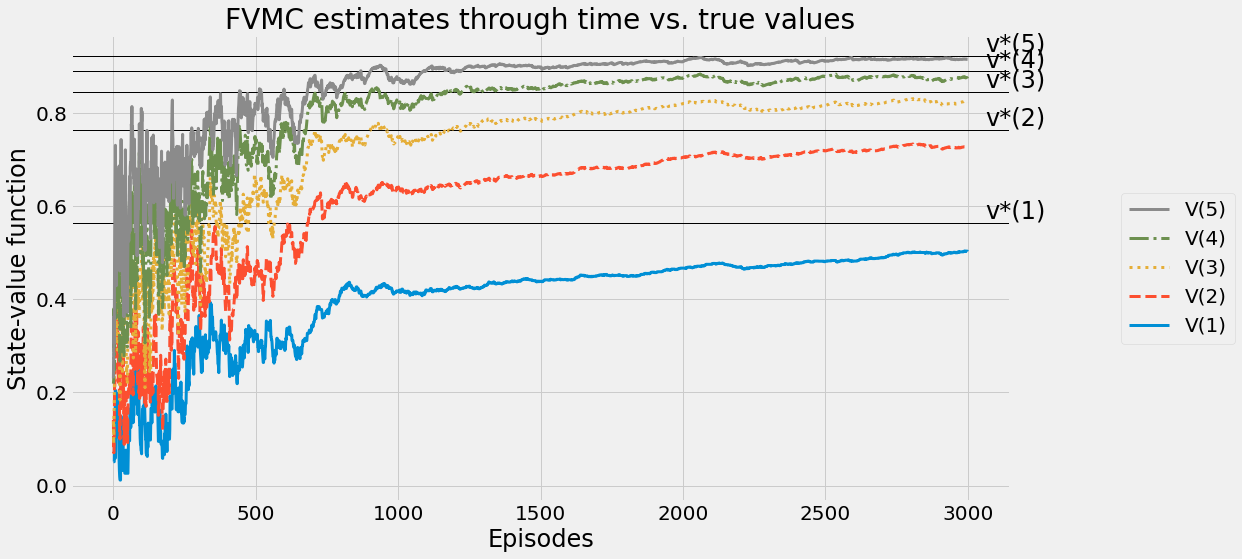

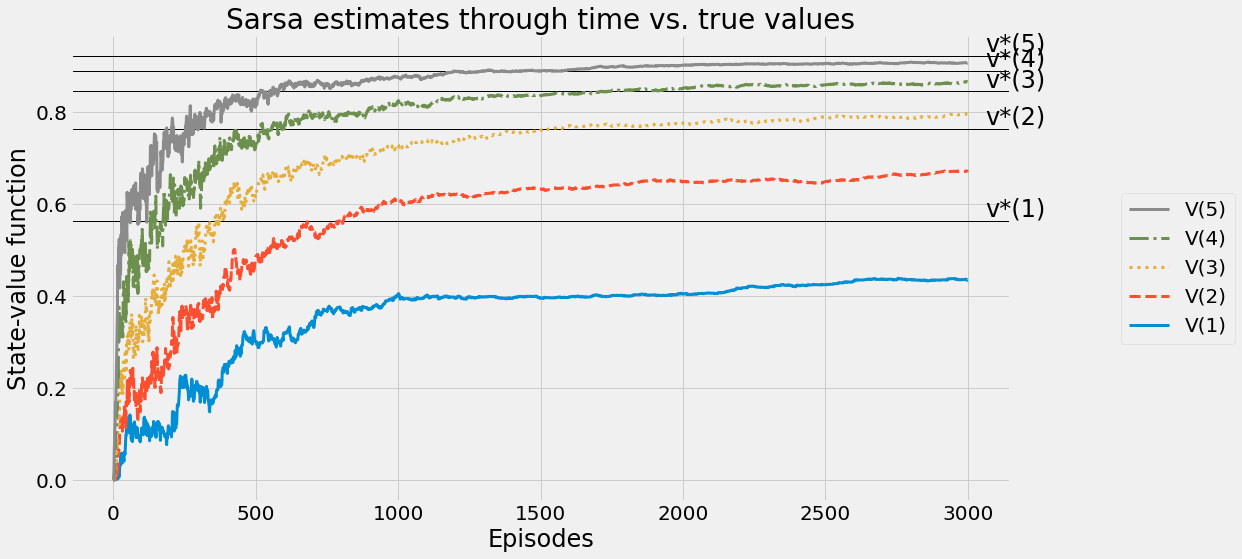

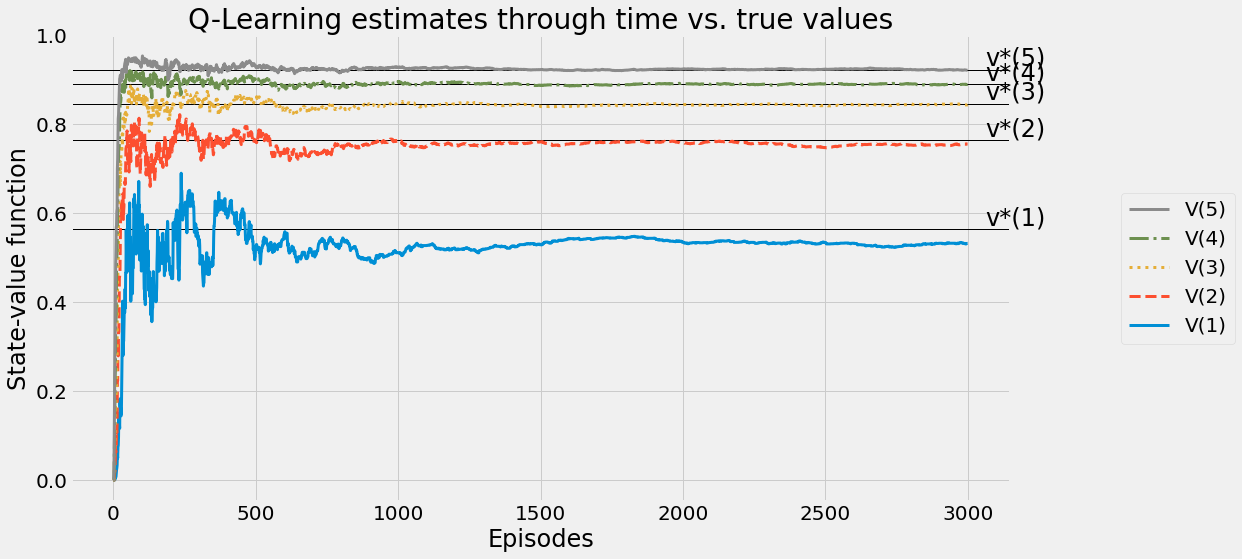

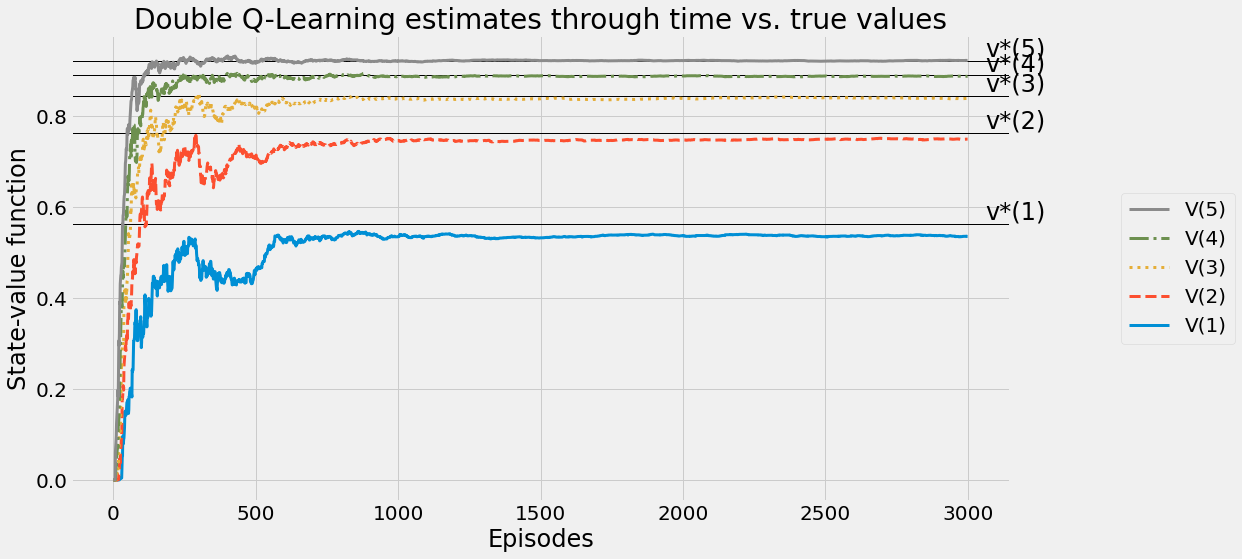

In [28]:
plot_value_function(
    'FVMC estimates through time vs. true values', 
    np.max(Q_track_mc, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)
plot_value_function(
    'Sarsa estimates through time vs. true values', 
    np.max(Q_track_sarsa, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)
plot_value_function(
    'Q-Learning estimates through time vs. true values', 
    np.max(Q_track_ql, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)
plot_value_function(
    'Double Q-Learning estimates through time vs. true values', 
    np.max(Q_track_dql, axis=2), 
    optimal_V,
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)

## Russell & Norvig's Gridworld

In [29]:
env = gym.make('RussellNorvigGridworld-v0')
init_state = env.reset()
goal_state = 3
gamma = 1.0
n_episodes = 4000
P = env.env.P
n_cols, svf_prec, err_prec, avg_prec = 4, 4, 2, 3
action_symbols = ('<', 'v', '>', '^')
limit_items, limit_value = 5, 0.01
cu_limit_items, cu_limit_value, cu_episodes = 10, 0.0, 1000

### Alpha and Epsilon schedules

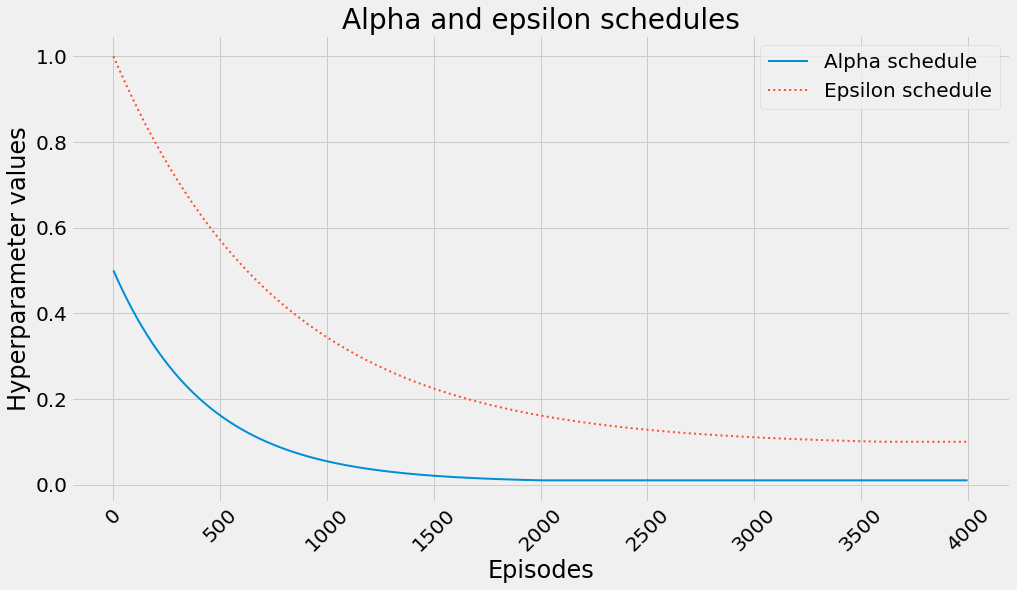

In [30]:
plt.plot(decay_schedule(0.5, 0.01, 0.5, n_episodes), 
         '-', linewidth=2, 
         label='Alpha schedule')
plt.plot(decay_schedule(1.0, 0.1, 0.9, n_episodes), 
         ':', linewidth=2, 
         label='Epsilon schedule')
plt.legend(loc=1, ncol=1)

plt.title('Alpha and epsilon schedules')
plt.xlabel('Episodes')
plt.ylabel('Hyperparameter values')
plt.xticks(rotation=45)

plt.show()

### Optimal value functions and policy

In [31]:
optimal_Q, optimal_V, optimal_pi = value_iteration(P, gamma=gamma)
print_state_value_function(optimal_V, P, n_cols=n_cols, prec=svf_prec, title='Optimal state-value function:')
print()

print_action_value_function(optimal_Q, 
                            None, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Optimal action-value function:')
print()
print_policy(optimal_pi, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_op, mean_return_op, mean_regret_op = get_policy_metrics(
    env, gamma=gamma, pi=optimal_pi, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_op, mean_return_op, mean_regret_op))

Optimal state-value function:
| 00 0.8116 | 01 0.8678 | 02 0.9178 |           |
| 04 0.7616 |           | 06 0.6603 |           |
| 08 0.7053 | 09 0.6553 | 10 0.6114 | 11 0.3879 |

Optimal action-value function:
╒═════╤═══════╤═══════╤════════╤════════╕
│   s │     < │     v │      > │      ^ │
╞═════╪═══════╪═══════╪════════╪════════╡
│   0 │ 0.767 │ 0.737 │  0.812 │  0.777 │
├─────┼───────┼───────┼────────┼────────┤
│   1 │ 0.783 │ 0.827 │  0.868 │  0.827 │
├─────┼───────┼───────┼────────┼────────┤
│   2 │ 0.812 │ 0.675 │  0.918 │  0.881 │
├─────┼───────┼───────┼────────┼────────┤
│   3 │ 0     │ 0     │  0     │  0     │
├─────┼───────┼───────┼────────┼────────┤
│   4 │ 0.721 │ 0.677 │  0.721 │  0.762 │
├─────┼───────┼───────┼────────┼────────┤
│   5 │ 0     │ 0     │  0     │  0     │
├─────┼───────┼───────┼────────┼────────┤
│   6 │ 0.641 │ 0.415 │ -0.687 │  0.66  │
├─────┼───────┼───────┼────────┼────────┤
│   7 │ 0     │ 0     │  0     │  0     │
├─────┼───────┼───────┼────────┼

### MC control

In [32]:
%%capture
Q_mcs, V_mcs, Q_track_mcs = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_mc, V_mc, pi_mc, Q_track_mc, pi_track_mc = mc_control(env, gamma=gamma, n_episodes=n_episodes)
    Q_mcs.append(Q_mc) ; V_mcs.append(V_mc) ; Q_track_mcs.append(Q_track_mc)
Q_mc, V_mc, Q_track_mc = np.mean(Q_mcs, axis=0), np.mean(V_mcs, axis=0), np.mean(Q_track_mcs, axis=0)
del Q_mcs ; del V_mcs ; del Q_track_mcs

In [33]:
print_state_value_function(V_mc, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by FVMC:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_mc - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_mc, optimal_V)))
print()
print_action_value_function(Q_mc, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='FVMC action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_mc, optimal_Q)))
print()
print_policy(pi_mc, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_mc, mean_return_mc, mean_regret_mc = get_policy_metrics(
    env, gamma=gamma, pi=pi_mc, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_mc, mean_return_mc, mean_regret_mc))

State-value function found by FVMC:
| 00 0.7801 | 01 0.8529 | 02 0.9236 |           |
| 04 0.6721 |           | 06 0.6145 |           |
| 08 0.6163 | 09 0.4779 | 10  0.386 | 11 0.0033 |
Optimal state-value function:
| 00 0.8116 | 01 0.8678 | 02 0.9178 |           |
| 04 0.7616 |           | 06 0.6603 |           |
| 08 0.7053 | 09 0.6553 | 10 0.6114 | 11 0.3879 |
State-value function errors:
| 00  -0.03 | 01  -0.01 | 02   0.01 |           |
| 04  -0.09 |           | 06  -0.05 |           |
| 08  -0.09 | 09  -0.18 | 10  -0.23 | 11  -0.38 |
State-value function RMSE: 0.1442

FVMC action-value function:
╒═════╤════════╤════════╤════════╤════════╤═══════╤═══════╤════════╤════════╤═════════╤═════════╤═════════╤═════════╕
│   s │      < │      v │      > │      ^ │   * < │   * v │    * > │    * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪════════╪════════╪════════╪════════╪═══════╪═══════╪════════╪════════╪═════════╪═════════╪═════════╪═════════╡
│   0 │  0.503 │  0.506 │  0.78  │  0.

### SARSA

In [34]:
%%capture
Q_sarsas, V_sarsas, Q_track_sarsas = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_sarsa, V_sarsa, pi_sarsa, Q_track_sarsa, pi_track_sarsa = sarsa(env, gamma=gamma, n_episodes=n_episodes)
    Q_sarsas.append(Q_sarsa) ; V_sarsas.append(V_sarsa) ; Q_track_sarsas.append(Q_track_sarsa)
Q_sarsa = np.mean(Q_sarsas, axis=0)
V_sarsa = np.mean(V_sarsas, axis=0)
Q_track_sarsa = np.mean(Q_track_sarsas, axis=0)
del Q_sarsas ; del V_sarsas ; del Q_track_sarsas

In [35]:
print_state_value_function(V_sarsa, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by Sarsa:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_sarsa - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_sarsa, optimal_V)))
print()
print_action_value_function(Q_sarsa, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Sarsa action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_sarsa, optimal_Q)))
print()
print_policy(pi_sarsa, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_sarsa, mean_return_sarsa, mean_regret_sarsa = get_policy_metrics(
    env, gamma=gamma, pi=pi_sarsa, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_sarsa, mean_return_sarsa, mean_regret_sarsa))

State-value function found by Sarsa:
| 00 0.7686 | 01 0.8367 | 02 0.9032 |           |
| 04 0.7077 |           | 06 0.6143 |           |
| 08 0.6203 | 09   0.53 | 10 0.2501 | 11 -0.4227 |
Optimal state-value function:
| 00 0.8116 | 01 0.8678 | 02 0.9178 |           |
| 04 0.7616 |           | 06 0.6603 |           |
| 08 0.7053 | 09 0.6553 | 10 0.6114 | 11 0.3879 |
State-value function errors:
| 00  -0.04 | 01  -0.03 | 02  -0.01 |           |
| 04  -0.05 |           | 06  -0.05 |           |
| 08  -0.08 | 09  -0.13 | 10  -0.36 | 11  -0.81 |
State-value function RMSE: 0.2612

Sarsa action-value function:
╒═════╤════════╤════════╤════════╤════════╤═══════╤═══════╤════════╤════════╤═════════╤═════════╤═════════╤═════════╕
│   s │      < │      v │      > │      ^ │   * < │   * v │    * > │    * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪════════╪════════╪════════╪════════╪═══════╪═══════╪════════╪════════╪═════════╪═════════╪═════════╪═════════╡
│   0 │  0.654 │  0.616 │  0.769 │ 

### Q-learning

In [36]:
%%capture
Q_qls, V_qls, Q_track_qls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_ql, V_ql, pi_ql, Q_track_ql, pi_track_ql = q_learning(env, gamma=gamma, n_episodes=n_episodes)
    Q_qls.append(Q_ql) ; V_qls.append(V_ql) ; Q_track_qls.append(Q_track_ql)
Q_ql = np.mean(Q_qls, axis=0)
V_ql = np.mean(V_qls, axis=0)
Q_track_ql = np.mean(Q_track_qls, axis=0)
del Q_qls ; del V_qls ; del Q_track_qls

In [37]:
print_state_value_function(V_ql, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by Q-learning:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_ql - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_ql, optimal_V)))
print()
print_action_value_function(Q_ql, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Q-learning action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_ql, optimal_Q)))
print()
print_policy(pi_ql, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_ql, mean_return_ql, mean_regret_ql = get_policy_metrics(
    env, gamma=gamma, pi=pi_ql, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_ql, mean_return_ql, mean_regret_ql))

State-value function found by Q-learning:
| 00 0.8094 | 01  0.866 | 02 0.9189 |           |
| 04  0.759 |           | 06 0.6328 |           |
| 08 0.7026 | 09 0.6534 | 10 0.6042 | 11 0.4023 |
Optimal state-value function:
| 00 0.8116 | 01 0.8678 | 02 0.9178 |           |
| 04 0.7616 |           | 06 0.6603 |           |
| 08 0.7053 | 09 0.6553 | 10 0.6114 | 11 0.3879 |
State-value function errors:
| 00   -0.0 | 01   -0.0 | 02    0.0 |           |
| 04   -0.0 |           | 06  -0.03 |           |
| 08   -0.0 | 09   -0.0 | 10  -0.01 | 11   0.01 |
State-value function RMSE: 0.0093

Q-learning action-value function:
╒═════╤═══════╤═══════╤════════╤════════╤═══════╤═══════╤════════╤════════╤═════════╤═════════╤═════════╤═════════╕
│   s │     < │     v │      > │      ^ │   * < │   * v │    * > │    * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪═══════╪═══════╪════════╪════════╪═══════╪═══════╪════════╪════════╪═════════╪═════════╪═════════╪═════════╡
│   0 │ 0.766 │ 0.737 │  0.809 │

### Double Q-learning

In [38]:
%%capture
Q_dqls, V_dqls, Q_track_dqls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_dql, V_dql, pi_dql, Q_track_dql, pi_track_dql = double_q_learning(env, gamma=gamma, n_episodes=n_episodes)
    Q_dqls.append(Q_dql) ; V_dqls.append(V_dql) ; Q_track_dqls.append(Q_track_dql)
Q_dql, V_dql, Q_track_dql = np.mean(Q_dqls, axis=0), np.mean(V_dqls, axis=0), np.mean(Q_track_dqls, axis=0)
del Q_dqls ; del V_dqls ; del Q_track_dqls

In [39]:
print_state_value_function(V_dql, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by Double Q-Learning:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_dql - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_dql, optimal_V)))
print()
print_action_value_function(Q_dql, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Double Q-Learning action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_dql, optimal_Q)))
print()
print_policy(pi_dql, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_dql, mean_return_dql, mean_regret_dql = get_policy_metrics(
    env, gamma=gamma, pi=pi_dql, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_dql, mean_return_dql, mean_regret_dql))

State-value function found by Double Q-Learning:
| 00 0.8075 | 01 0.8607 | 02 0.9125 |           |
| 04 0.7584 |           | 06 0.6238 |           |
| 08 0.7021 | 09 0.6488 | 10 0.5896 | 11  0.311 |
Optimal state-value function:
| 00 0.8116 | 01 0.8678 | 02 0.9178 |           |
| 04 0.7616 |           | 06 0.6603 |           |
| 08 0.7053 | 09 0.6553 | 10 0.6114 | 11 0.3879 |
State-value function errors:
| 00   -0.0 | 01  -0.01 | 02  -0.01 |           |
| 04   -0.0 |           | 06  -0.04 |           |
| 08   -0.0 | 09  -0.01 | 10  -0.02 | 11  -0.08 |
State-value function RMSE: 0.0256

Double Q-Learning action-value function:
╒═════╤═══════╤═══════╤════════╤════════╤═══════╤═══════╤════════╤════════╤═════════╤═════════╤═════════╤═════════╕
│   s │     < │     v │      > │      ^ │   * < │   * v │    * > │    * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪═══════╪═══════╪════════╪════════╪═══════╪═══════╪════════╪════════╪═════════╪═════════╪═════════╪═════════╡
│   0 │ 0.759 │ 0.

### Comparisons of max(Q) for every episode

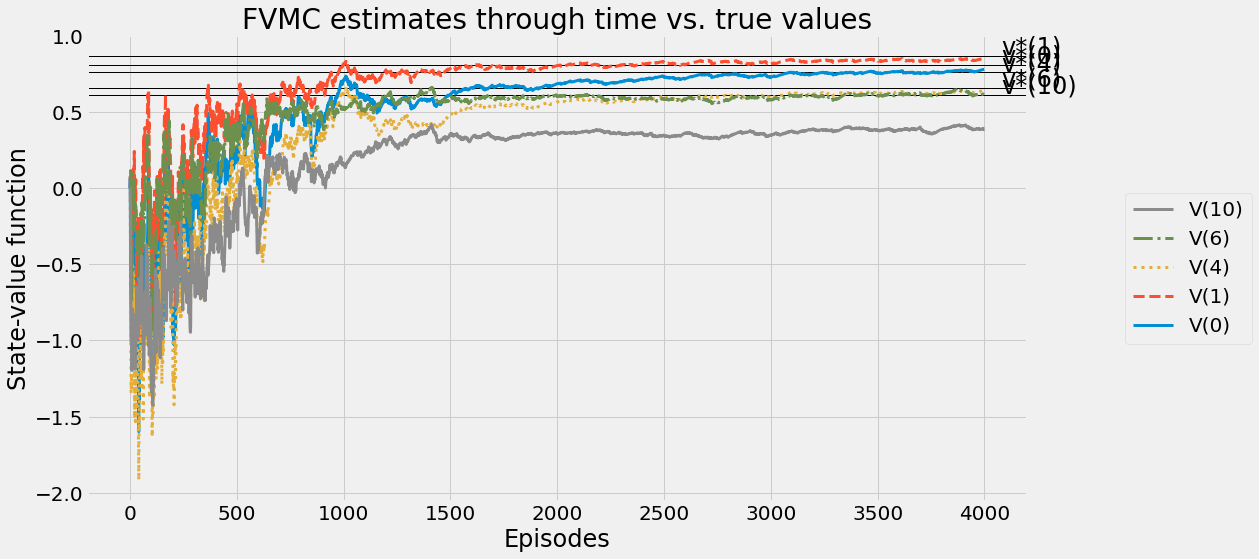

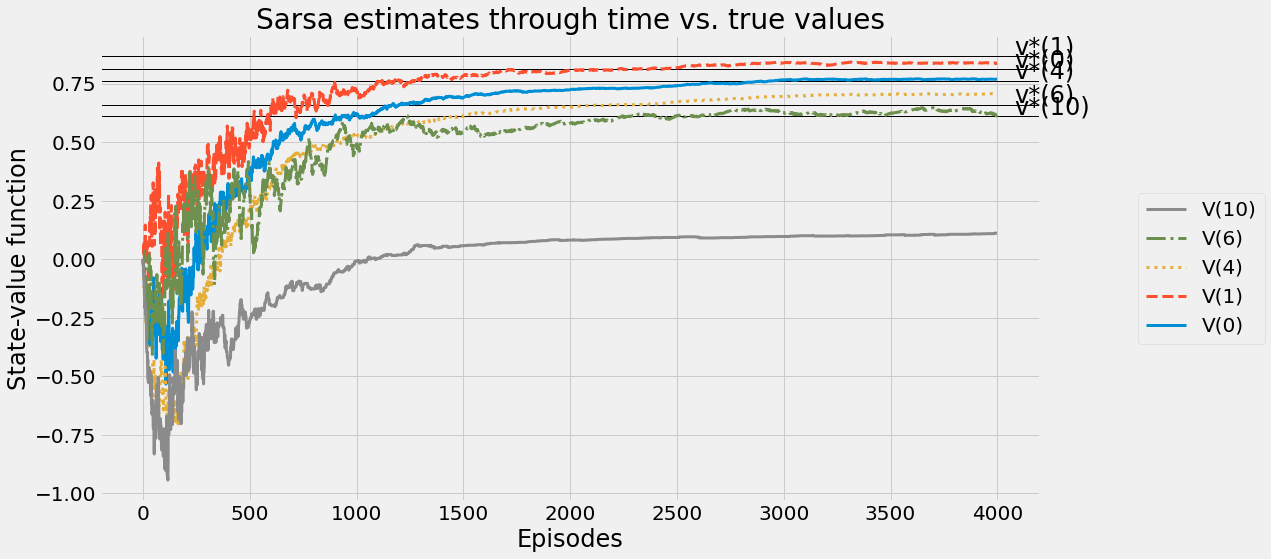

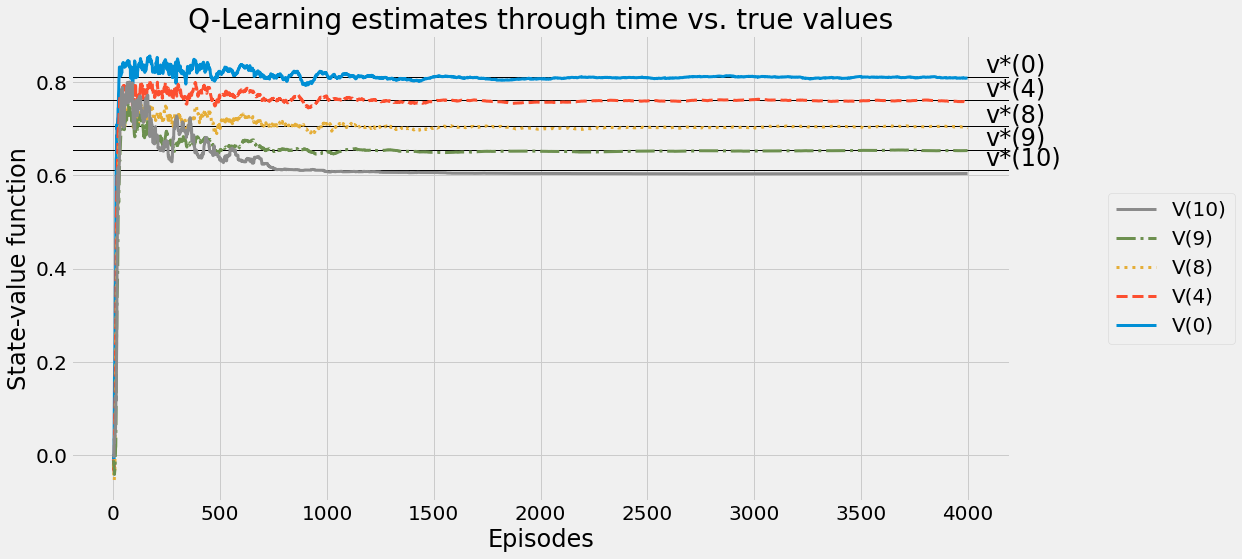

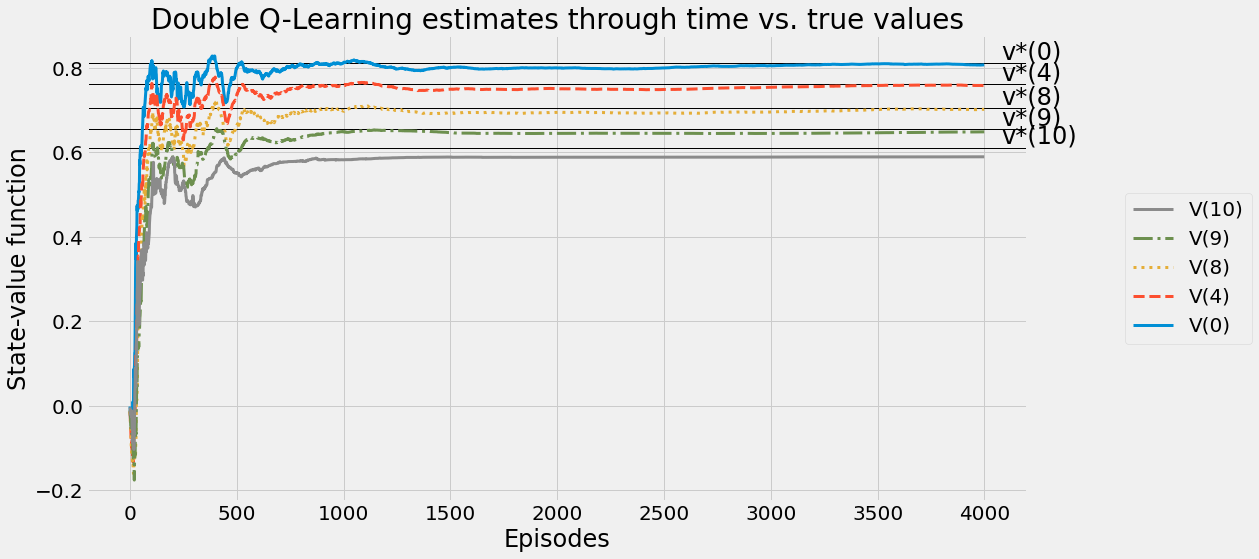

In [40]:
plot_value_function(
    'FVMC estimates through time vs. true values', 
    np.max(Q_track_mc, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)
plot_value_function(
    'Sarsa estimates through time vs. true values', 
    np.max(Q_track_sarsa, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)
plot_value_function(
    'Q-Learning estimates through time vs. true values', 
    np.max(Q_track_ql, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)
plot_value_function(
    'Double Q-Learning estimates through time vs. true values', 
    np.max(Q_track_dql, axis=2), 
    optimal_V,
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)

### Policy evoluation comparison

In [42]:
%%capture
mc_success_rate_ma, mc_mean_return_ma, mc_mean_regret_ma = get_metrics_from_tracks(
    env, gamma, goal_state, optimal_Q, pi_track_mc)
sarsa_success_rate_ma, sarsa_mean_return_ma, sarsa_mean_regret_ma = get_metrics_from_tracks(
    env, gamma, goal_state, optimal_Q, pi_track_sarsa)
ql_success_rate_ma, ql_mean_return_ma, ql_mean_regret_ma = get_metrics_from_tracks(
    env, gamma, goal_state, optimal_Q, pi_track_ql)
dql_success_rate_ma, dql_mean_return_ma, dql_mean_regret_ma = get_metrics_from_tracks(
    env, gamma, goal_state, optimal_Q, pi_track_dql)

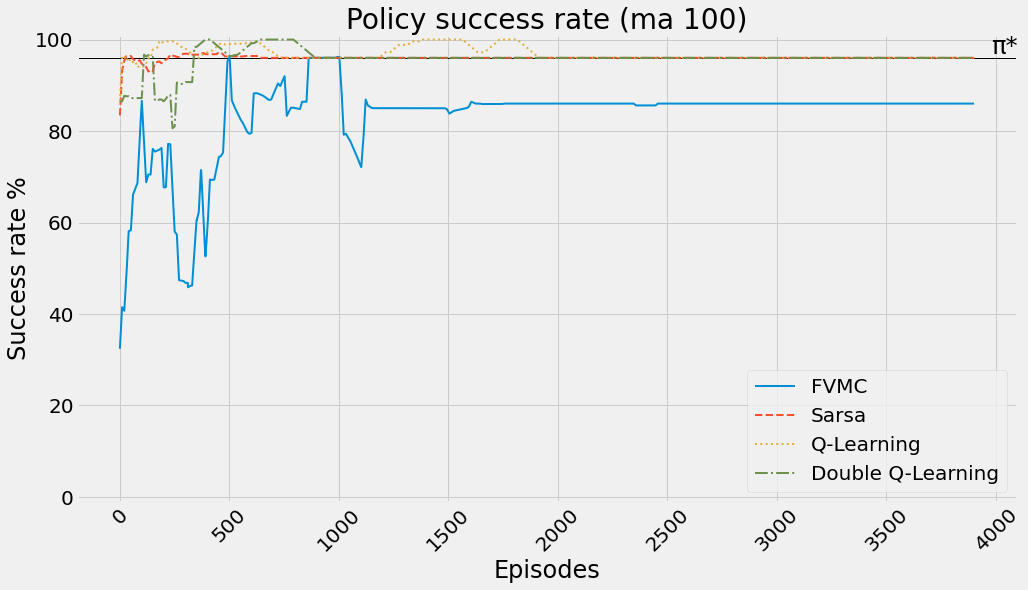

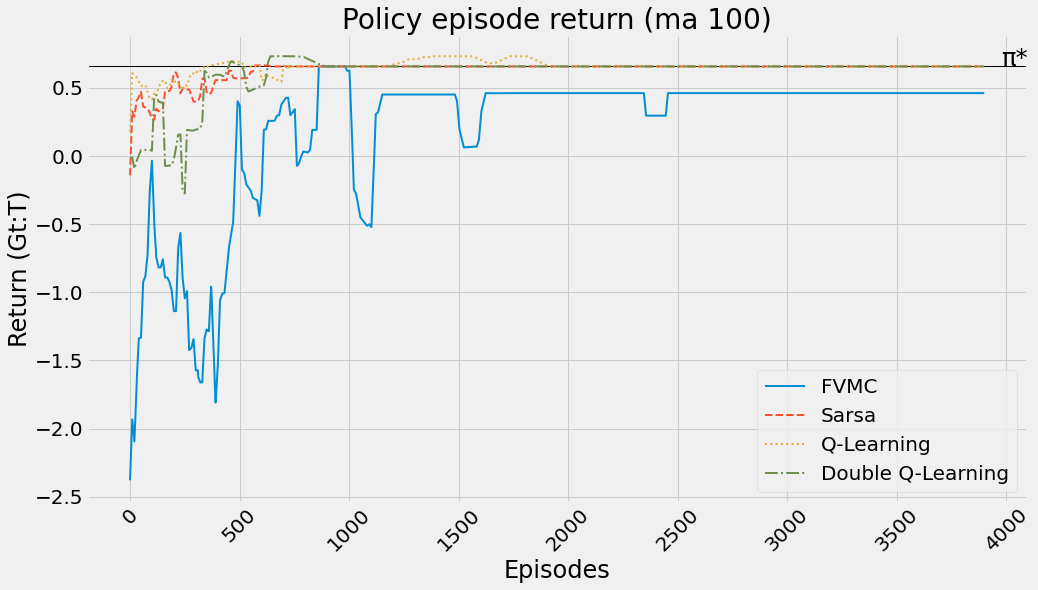

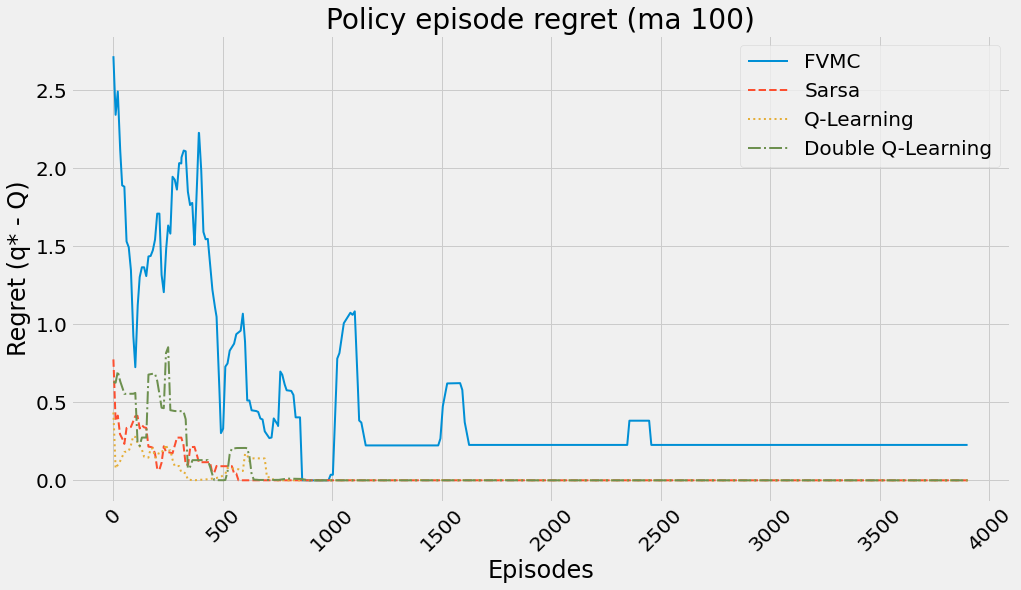

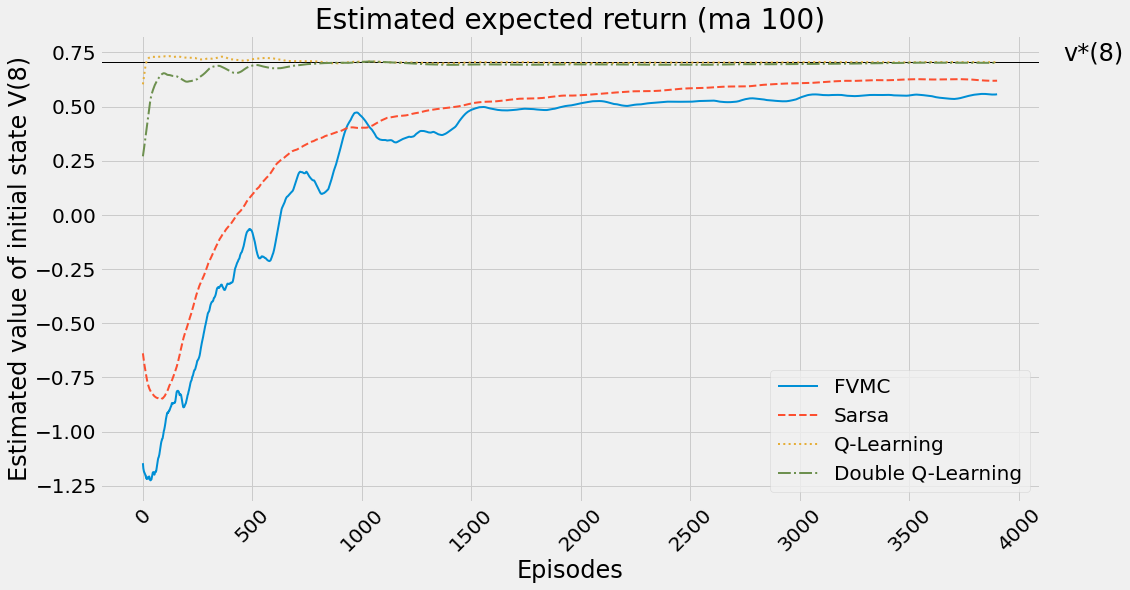

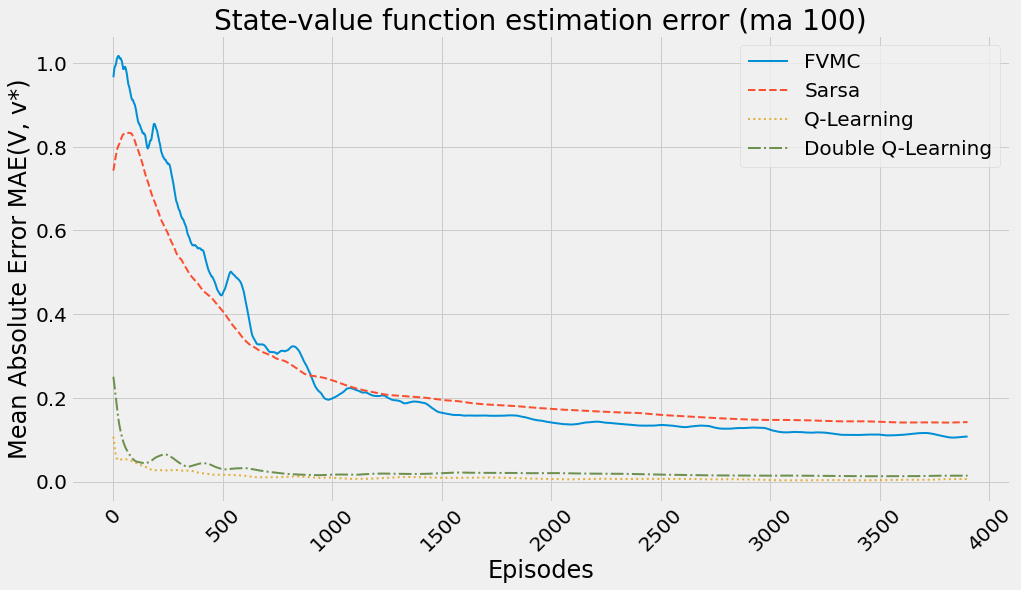

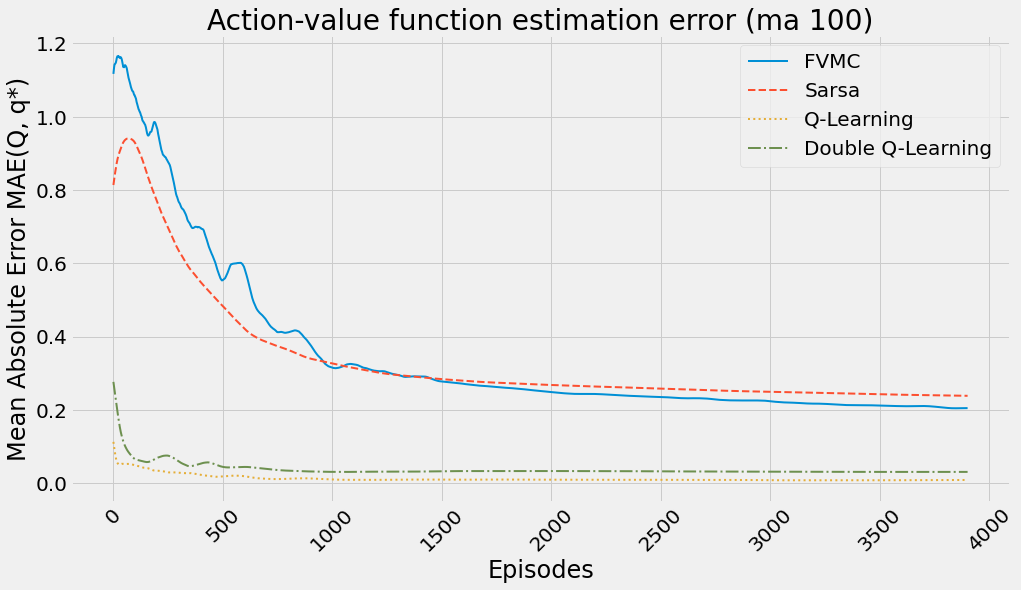

In [43]:
plt.axhline(y=success_rate_op, color='k', linestyle='-', linewidth=1)
plt.text(int(len(mc_success_rate_ma)*1.02), success_rate_op*1.01, 'π*')

plt.plot(mc_success_rate_ma, '-', linewidth=2, label='FVMC')
plt.plot(sarsa_success_rate_ma, '--', linewidth=2, label='Sarsa')
plt.plot(ql_success_rate_ma, ':', linewidth=2, label='Q-Learning')
plt.plot(dql_success_rate_ma, '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=4, ncol=1)

plt.title('Policy success rate (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Success rate %')
plt.ylim(-1, 101)
plt.xticks(rotation=45)

plt.show()

plt.axhline(y=mean_return_op, color='k', linestyle='-', linewidth=1)
plt.text(int(len(mc_mean_return_ma)*1.02), mean_return_op*1.01, 'π*')

plt.plot(mc_mean_return_ma, '-', linewidth=2, label='FVMC')
plt.plot(sarsa_mean_return_ma, '--', linewidth=2, label='Sarsa')
plt.plot(ql_mean_return_ma, ':', linewidth=2, label='Q-Learning')
plt.plot(dql_mean_return_ma, '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=4, ncol=1)

plt.title('Policy episode return (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Return (Gt:T)')

plt.xticks(rotation=45)

plt.show()


plt.plot(mc_mean_regret_ma, '-', linewidth=2, label='FVMC')
plt.plot(sarsa_mean_regret_ma, '--', linewidth=2, label='Sarsa')
plt.plot(ql_mean_regret_ma, ':', linewidth=2, label='Q-Learning')
plt.plot(dql_mean_regret_ma, '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=1, ncol=1)

plt.title('Policy episode regret (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Regret (q* - Q)')
plt.xticks(rotation=45)

plt.show()


plt.axhline(y=optimal_V[init_state], color='k', linestyle='-', linewidth=1)
plt.text(int(len(Q_track_mc)*1.05), optimal_V[init_state]+.01, 'v*({})'.format(init_state))

plt.plot(moving_average(np.max(Q_track_mc, axis=2).T[init_state]), 
         '-', linewidth=2, label='FVMC')
plt.plot(moving_average(np.max(Q_track_sarsa, axis=2).T[init_state]), 
         '--', linewidth=2, label='Sarsa')
plt.plot(moving_average(np.max(Q_track_ql, axis=2).T[init_state]), 
         ':', linewidth=2, label='Q-Learning')
plt.plot(moving_average(np.max(Q_track_dql, axis=2).T[init_state]), 
         '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=4, ncol=1)

plt.title('Estimated expected return (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Estimated value of initial state V({})'.format(init_state))
plt.xticks(rotation=45)

plt.show()


plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_mc, axis=2) - optimal_V), axis=1)), 
         '-', linewidth=2, label='FVMC')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_sarsa, axis=2) - optimal_V), axis=1)), 
         '--', linewidth=2, label='Sarsa')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_ql, axis=2) - optimal_V), axis=1)), 
         ':', linewidth=2, label='Q-Learning')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_dql, axis=2) - optimal_V), axis=1)), 
         '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=1, ncol=1)

plt.title('State-value function estimation error (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error MAE(V, v*)')
plt.xticks(rotation=45)

plt.show()


plt.plot(moving_average(np.mean(np.abs(Q_track_mc - optimal_Q), axis=(1,2))), 
         '-', linewidth=2, label='FVMC')
plt.plot(moving_average(np.mean(np.abs(Q_track_sarsa - optimal_Q), axis=(1,2))), 
         '--', linewidth=2, label='Sarsa')
plt.plot(moving_average(np.mean(np.abs(Q_track_ql - optimal_Q), axis=(1,2))), 
         ':', linewidth=2, label='Q-Learning')
plt.plot(moving_average(np.mean(np.abs(Q_track_dql - optimal_Q), axis=(1,2))), 
         '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=1, ncol=1)

plt.title('Action-value function estimation error (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error MAE(Q, q*)')
plt.xticks(rotation=45)

plt.show()